In [256]:
import numpy as np
import pandas as pd
import matplotlib as plt
import graphviz
import scipy as sp
from sklearn import preprocessing, compose, model_selection, pipeline, naive_bayes, impute, tree, base, ensemble

In [134]:
class SparseTransformer(base.TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return sp.sparse.csc_matrix(X)

# The Data

In [2]:
labeled_data = pd.read_excel('data/existing-customers.xlsx', engine="openpyxl")
unlabeled_data = pd.read_excel('data/potential-customers.xlsx', engine="openpyxl")

/Users/noah/Documents/School/Ma1 Informatica/Data Mining/data-mining/assignment1/env/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/noah/Documents/School/Ma1 Informatica/Data Mining/data-mining/assignment1/env/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


## Inspecting the data

In [27]:
labeled_data.head()

,RowID,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,Row0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,Row1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,Row2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,Row3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,Row4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
labeled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   RowID           32561 non-null  object
 1   age             32561 non-null  int64 
 2   workclass       30725 non-null  object
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  class           32561 non-null  object
dtypes: int64(5), object(10)
memory usage: 3.7+ MB


In [50]:
labeled_data['workclass'].value_counts()

workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64

In [57]:
labeled_data['education'].value_counts()

education
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: count, dtype: int64

In [52]:
labeled_data['marital-status'].value_counts()

marital-status
Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: count, dtype: int64

In [54]:
labeled_data['occupation'].value_counts()

occupation
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: count, dtype: int64

In [10]:
labeled_data.isna().sum()

RowID                0
age                  0
workclass         1836
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
class                0
dtype: int64

In [6]:
a = labeled_data.shape[0]
b = labeled_data.dropna().shape[0]

a, b, (a-b)/a

(32561, 30162, 0.07367709836921471)

There are ~2000 rows (7%) which contain one or more missing values

In [25]:
a = labeled_data['class'].value_counts()
b = labeled_data.dropna()['class'].value_counts()
an = a['<=50K']
ap = a['>50K']
bn = b['<=50K']
bp = b['>50K']

ap/(ap+an), bp/(bp+bn)

(0.2408095574460244, 0.24892248524633645)

The positive (>50K) class is under represented in the data. Around 25% of examples have positive label.

## Split data into training and testing

In [34]:
label_col = 'class'
forbidden_features = ['race', 'sex', label_col]
X = labeled_data.drop(forbidden_features, axis=1)
y = labeled_data[label_col]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.4, random_state=0)
X_train.head()

,RowID,age,workclass,education,education-num,marital-status,occupation,relationship,capital-gain,capital-loss,hours-per-week,native-country
27983,Row27983,46,Private,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,0,0,50,United-States
12893,Row12893,49,Local-gov,Masters,14,Widowed,Prof-specialty,Unmarried,0,0,16,United-States
578,Row578,58,Local-gov,Bachelors,13,Never-married,Prof-specialty,Not-in-family,0,0,40,United-States
28263,Row28263,19,Private,11th,7,Never-married,Handlers-cleaners,Other-relative,0,0,30,United-States
24254,Row24254,66,Private,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,0,0,40,United-States


# Models
## Naive Bayes

In [379]:
def create_nb_pipeline():
    cat_features = ['workclass', 'education', 'marital-status', 'occupation', 'native-country']
    # num_features = ['age', 'hours-per-week']
    
    # allowed to look at all data because we know all the possible values
    # could be replaced with manually typing out all possible values
    full_data = pd.concat((labeled_data, unlabeled_data))
    categories = [list(full_data[f].unique()) for f in cat_features]
    
    b1 = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal')
    b2 = preprocessing.KBinsDiscretizer(n_bins=3, encode='ordinal', strategy="uniform")
    o = preprocessing.OrdinalEncoder(categories=categories)

    transformer = compose.ColumnTransformer(
        [
            ('b1', b1, ['age']),
            ('b2', b2, ['hours-per-week']),
            ('o', o, cat_features),

        ],
        remainder='drop', verbose_feature_names_out=False
    )
    i = impute.KNNImputer()
    nb = naive_bayes.CategoricalNB(min_categories=[5, 3, *[len(c) for c in categories]])

    return pipeline.Pipeline([('t', transformer), ('i', i), ('nb', nb)])

create_nb_pipeline()

Pipeline(steps=[('t',
                 ColumnTransformer(transformers=[('b1',
                                                  KBinsDiscretizer(encode='ordinal'),
                                                  ['age']),
                                                 ('b2',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=3,
                                                                   strategy='uniform'),
                                                  ['hours-per-week']),
                                                 ('o',
                                                  OrdinalEncoder(categories=[['State-gov',
                                                                              'Self-emp-not-inc',
                                                                              'Private',
                                                                              'Federal-gov',
                                                                              'Local-gov',
                                                                              nan,
                                                                              'Self-emp-inc',
                                                                              'Without-pay',
                                                                              'Never-worked'],
                                                                             ['Bachelo...
                                                                              'Poland',
                                                                              'Columbia',
                                                                              'Cambodia',
                                                                              'Thailand',
                                                                              'Ecuador',
                                                                              'Laos',
                                                                              'Taiwan',
                                                                              'Haiti',
                                                                              'Portugal',
                                                                              'Dominican-Republic',
                                                                              'El-Salvador',
                                                                              'France',
                                                                              'Guatemala',
                                                                              'China',
                                                                              'Japan', ...]]),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation',
                                                   'native-country'])],
                                   verbose_feature_names_out=False)),
                ('i', KNNImputer()),
                ('nb', CategoricalNB(min_categories=[5, 3, 9, 16, 7, 15, 42]))])

In [254]:
# tune hyperparameters with cross validation
nb_grid_search = model_selection.GridSearchCV(create_nb_pipeline(), param_grid={
    't__b1__n_bins': [2, 5, 10, 20],
    't__b2__n_bins': [2, 3, 5],
    'nb__alpha': [0.1, 0.2, 0.3]
})
nb_grid_search.fit(X_train, y_train)
nb_grid_search.best_params_

{'nb__alpha': 0.3, 't__b1__n_bins': 10, 't__b2__n_bins': 3}

In [381]:
# fit and test with tuned hyperparameters
nb_p = create_nb_pipeline()
nb_p.set_params(**nb_grid_search.best_params_)
nb_p.fit(X_train, y_train)
nb_p.score(X_test, y_test)

0.8252591170825336

## Decision Trees

In [232]:
def create_dt_pipeline():
    cat_features = ['workclass', 'marital-status', 'occupation']
    num_features = ['age', 'hours-per-week', 'education-num', 'capital-gain', 'capital-loss']
    
    # allowed to look at all data because we know all the possible values
    # could be replaced with manually typing out all possible values
    full_data = pd.concat((labeled_data, unlabeled_data))
    categories = [list(full_data[f].unique()) for f in cat_features]
    
    onehot = preprocessing.OneHotEncoder(categories=categories, sparse_output=False)

    t = compose.ColumnTransformer(
        [
            ('o', onehot, cat_features),
            ('p', 'passthrough', num_features)

        ],
        remainder='drop', verbose_feature_names_out=False
    )
    i = impute.KNNImputer()
    st = SparseTransformer()
    dt = tree.DecisionTreeClassifier()


    return pipeline.Pipeline([('t', t), ('i', i), ('st', st), ('dt', dt)])

create_dt_pipeline()

Pipeline(steps=[('t',
                 ColumnTransformer(transformers=[('o',
                                                  OneHotEncoder(categories=[['State-gov',
                                                                             'Self-emp-not-inc',
                                                                             'Private',
                                                                             'Federal-gov',
                                                                             'Local-gov',
                                                                             nan,
                                                                             'Self-emp-inc',
                                                                             'Without-pay',
                                                                             'Never-worked'],
                                                                            ['Never-married',
                                                                             'Married-civ-spouse',
                                                                             'Divorced',
                                                                             'Married-spouse-absent',
                                                                             'Separated',
                                                                             'Married-AF-spouse',
                                                                             'Widowed'],
                                                                            ['Adm-clerical',
                                                                             'Exec-managerial'...
                                                                             'Protective-serv',
                                                                             'Armed-Forces',
                                                                             'Priv-house-serv']],
                                                                sparse_output=False),
                                                  ['workclass',
                                                   'marital-status',
                                                   'occupation']),
                                                 ('p', 'passthrough',
                                                  ['age', 'hours-per-week',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss'])],
                                   verbose_feature_names_out=False)),
                ('i', KNNImputer()),
                ('st', <__main__.SparseTransformer object at 0x28eb2e310>),
                ('dt', DecisionTreeClassifier())])

In [197]:
counts = y_train.value_counts()

a = X_train[y_train=='>50K'].sample(counts.min())
b = X_train[y_train=='<=50K'].sample(counts.min())

X_train_dt = pd.concat((a, b)).sort_index()
y_train_dt = y_train[X_train_dt.index]

In [236]:
# tune hyperparameters with cross validation
dt_grid_search = model_selection.GridSearchCV(create_dt_pipeline(), param_grid={
    'dt__min_samples_leaf': [1, 5, 10, 50, 100],
    'dt__max_leaf_nodes': [None, 25, 50, 75, 100, 150],
})
dt_grid_search.fit(X_train, y_train)
dt_grid_search.best_params_

{'dt__max_leaf_nodes': 100, 'dt__min_samples_leaf': 1}

In [382]:
# fit and test with tuned hyperparameters
dt_p = create_dt_pipeline()
dt_p.set_params(**dt_grid_search.best_params_)
dt_p.fit(X_train, y_train)
dt_p.score(X_test, y_test)

0.8620345489443378

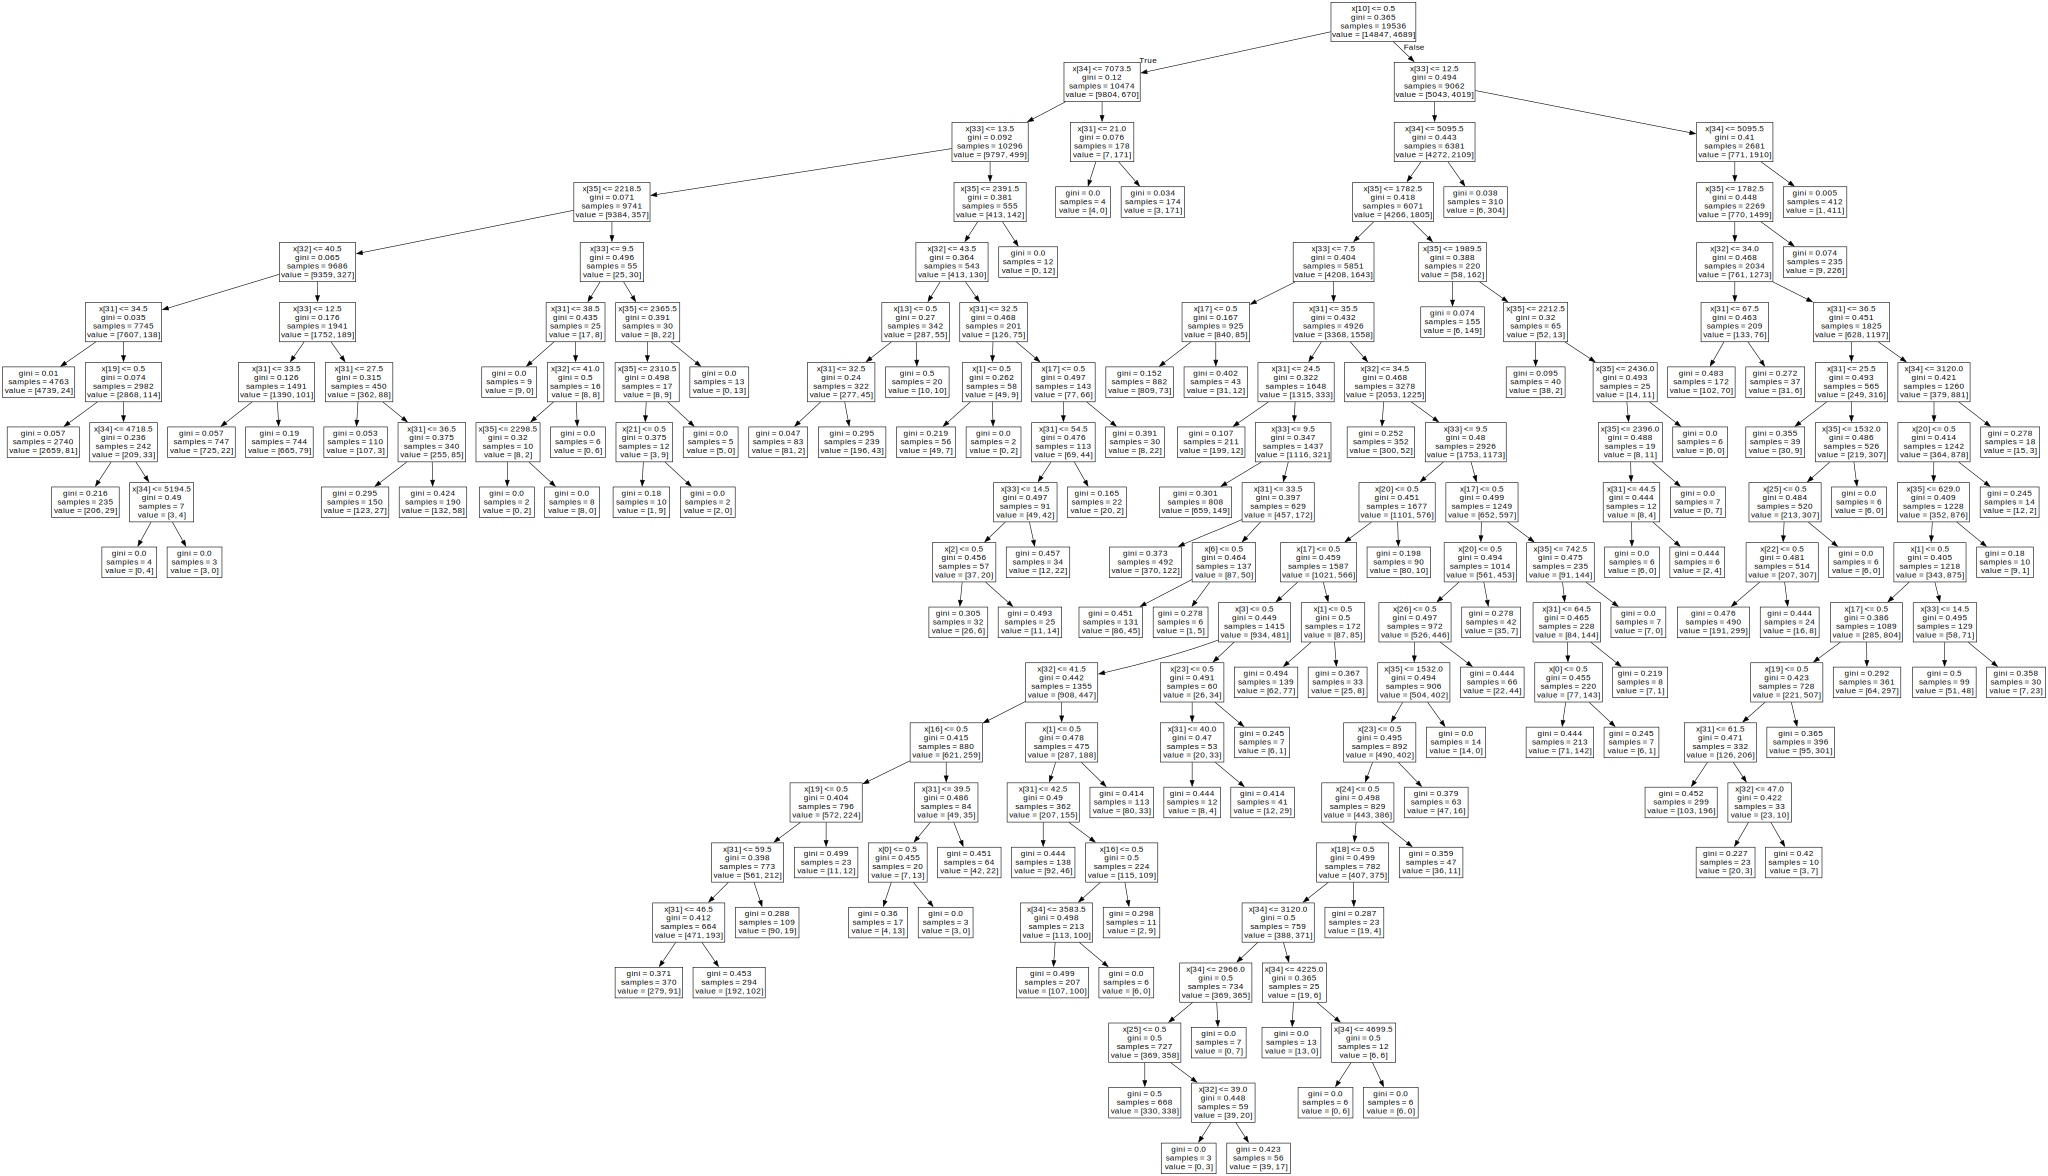

In [383]:
dot_data = tree.export_graphviz(dt_p.named_steps.dt, out_file=None)
graphviz.Source(dot_data)

Tested using balanced data (equal number of positive as negative labels but this resulted in worse performance.

## Random Forests

In [279]:
def create_rf_pipeline():
    cat_features = ['workclass', 'marital-status', 'occupation', 'native-country']
    num_features = ['age', 'hours-per-week', 'education-num', 'capital-gain', 'capital-loss']
    
    # allowed to look at all data because we know all the possible values
    # could be replaced with manually typing out all possible values
    full_data = pd.concat((labeled_data, unlabeled_data))
    categories = [list(full_data[f].unique()) for f in cat_features]
    
    onehot = preprocessing.OneHotEncoder(categories=categories, sparse_output=False)

    t = compose.ColumnTransformer(
        [
            ('o', onehot, cat_features),
            ('p', 'passthrough', num_features)

        ],
        remainder='drop', verbose_feature_names_out=False
    )
    i = impute.KNNImputer()
    st = SparseTransformer()
    rf = ensemble.RandomForestClassifier(n_jobs=-1)


    return pipeline.Pipeline([('t', t), ('i', i), ('st', st), ('rf', rf)])

create_rf_pipeline()

Pipeline(steps=[('t',
                 ColumnTransformer(transformers=[('o',
                                                  OneHotEncoder(categories=[['State-gov',
                                                                             'Self-emp-not-inc',
                                                                             'Private',
                                                                             'Federal-gov',
                                                                             'Local-gov',
                                                                             nan,
                                                                             'Self-emp-inc',
                                                                             'Without-pay',
                                                                             'Never-worked'],
                                                                            ['Never-married',
                                                                             'Married-civ-spouse',
                                                                             'Divorced',
                                                                             'Married-spouse-absent',
                                                                             'Separated',
                                                                             'Married-AF-spouse',
                                                                             'Widowed'],
                                                                            ['Adm-clerical',
                                                                             'Exec-managerial'...
                                                                             'Guatemala',
                                                                             'China',
                                                                             'Japan', ...]],
                                                                sparse_output=False),
                                                  ['workclass',
                                                   'marital-status',
                                                   'occupation',
                                                   'native-country']),
                                                 ('p', 'passthrough',
                                                  ['age', 'hours-per-week',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss'])],
                                   verbose_feature_names_out=False)),
                ('i', KNNImputer()),
                ('st', <__main__.SparseTransformer object at 0x16b2eedd0>),
                ('rf', RandomForestClassifier(n_jobs=-1))])

In [374]:
# tune hyperparameters with cross validation
rf_grid_search = model_selection.GridSearchCV(create_rf_pipeline(), param_grid={
    'rf__n_estimators': [100],
    'rf__max_depth': [None, 5, 10, 15],
    'rf__max_leaf_nodes': [50, 75, 100, 150],
    'rf__max_features': [None, 'sqrt', 0.3],
    'rf__max_samples': [0.5, 1.0]
}, cv=10)
rf_grid_search.fit(X_train, y_train)
rf_grid_search.best_params_

{'rf__max_depth': 15,
 'rf__max_features': None,
 'rf__max_leaf_nodes': 150,
 'rf__max_samples': 0.5,
 'rf__n_estimators': 100}

In [384]:
rf_p = create_rf_pipeline()
rf_p.set_params(**rf_grid_search.best_params_)
# p.set_params(**{
#     'rf__max_leaf_nodes': 80,
#     'rf__max_features': None, 
#     'rf__max_samples': 0.8,
#     'rf__n_estimators': 200,
# })
rf_p.fit(X_train, y_train)
rf_p.score(X_test, y_test)

0.8634932821497121

# Final Selection

Given a person $i$ who has probability $p_i$ of having high income. The expected revenue for that person is given by:

\begin{align}
\mathbb{E}[R(i)] &= 0.1 \cdot 980 \cdot p_i - 0.05 \cdot 310 \cdot (1-p_i)  - 10 \\
&= 113.5 \cdot p_i - 25.5
\end{align}

Which allows us to find the minimum probabibility for this expected revenue to be positive:

$$
\mathbb{E}[R(i)] \ge 0 \implies 113.5 \cdot p_i - 25.5 \ge 0 \implies p_i \ge 0.225
$$

Thus by selecting all potential customers with an estimated probability exceeding 22.5%, we will maximize the expected revenue $\mathbb{E}[R] = \sum_i{\mathbb{E}[R(i)]}$.

In [443]:
result = pd.DataFrame()
result['RowID'] = unlabeled_data['RowID']

result['Prediction'] = dt_p.predict(unlabeled_data)
result['ExpectedRevenue'] = np.add(np.multiply(dt_p.predict_proba(unlabeled_data)[:, 1], 113.5), -25.5)
result

,RowID,Prediction,ExpectedRevenue
0,Row0,<=50K,-24.928092
1,Row1,<=50K,12.333333
2,Row2,<=50K,2.644309
3,Row3,>50K,85.803226
4,Row4,<=50K,-24.928092
...,...,...,...
16276,Row16276,<=50K,-11.493617
16277,Row16277,<=50K,-22.144708
16278,Row16278,>50K,60.771465
16279,Row16279,<=50K,-22.144708


In [444]:
selection = result[result['ExpectedRevenue']>0]
selection

,RowID,Prediction,ExpectedRevenue
1,Row1,<=50K,12.333333
2,Row2,<=50K,2.644309
3,Row3,>50K,85.803226
7,Row7,<=50K,20.691860
10,Row10,>50K,85.803226
...,...,...,...
16265,Row16265,>50K,60.771465
16270,Row16270,<=50K,13.515625
16271,Row16271,<=50K,29.330918
16278,Row16278,>50K,60.771465


In [445]:
selection['RowID']

1            Row1
2            Row2
3            Row3
7            Row7
10          Row10
           ...   
16265    Row16265
16270    Row16270
16271    Row16271
16278    Row16278
16280    Row16280
Name: RowID, Length: 5582, dtype: object

In [446]:
selection['ExpectedRevenue'].sum()

229771.4483458685